## Evaluate the trained MS2DeepScore model on the reseverd test set
- test set: 500 InChIKeys, 3,601 spectra


In [1]:
import os
import pickle
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from ms2deepscore import SpectrumBinner
from ms2deepscore.models import SiameseModel

path_root = os.path.dirname(os.path.dirname(os.getcwd()))
path_data = os.path.join(path_root, 'Data')
path_models = os.path.join(path_root, 'SURF_model_training_runs')

## Additional plotting function

In [2]:
def precision_recall_plot(scores_test, scores_ref,
                          high_sim_threshold=0.6,
                          n_bins = 20):
    """Basic precision recall plot"""
    precisions = []
    recalls = []

    above_thres_total = np.sum(scores_ref >= high_sim_threshold)
    max_score = scores_test.max()
    min_score = scores_test.min()
    score_thresholds = np.linspace(min_score, max_score, n_bins+1)
    for low in score_thresholds:
        idx = np.where(scores_test>=low)
        above_thres = np.sum(scores_ref[idx] >= high_sim_threshold)
        below_thres = np.sum(scores_ref[idx] < high_sim_threshold)

        precisions.append(above_thres/(below_thres+above_thres))
        recalls.append(above_thres/above_thres_total)

    plt.figure(figsize=(6,5), dpi=120)
    plt.plot(recalls, precisions, "o--", color="crimson", label="precision/recall")
    #plt.plot(score_thresholds, precisions, "o--", color="crimson", label="precision")
    #plt.plot(score_thresholds, recalls, "o--", color="dodgerblue", label="recall")
    plt.legend()
    plt.xlabel("recall", fontsize=12)
    plt.ylabel("precision", fontsize=12)
    plt.title(f"precision/recall (high-similarity if Tanimoto > {high_sim_threshold })")
    plt.grid(True)
    
    return precisions, recalls

In [3]:
def tanimoto_dependent_losses(scores, scores_ref, ref_score_bins):
    """Compute errors (RMSE and MSE) for different bins of the reference scores (scores_ref).
    
    Parameters
    ----------
    
    scores
        Scores that should be evaluated
    scores_ref
        Reference scores (= ground truth).
    ref_score_bins
        Bins for the refernce score to evaluate the performance of scores.
    """
    bin_content = []
    rmses = []
    maes = []
    bounds = []
    ref_scores_bins_inclusive = ref_score_bins.copy()
    ref_scores_bins_inclusive[0] = -np.inf
    ref_scores_bins_inclusive[-1] = np.inf
    for i in range(len(ref_scores_bins_inclusive)-1):
        low = ref_scores_bins_inclusive[i]
        high = ref_scores_bins_inclusive[i+1]
        bounds.append((low, high))
        idx = np.where((scores_ref >= low) & (scores_ref < high))
        bin_content.append(idx[0].shape[0])
        maes.append(np.abs(scores_ref[idx] - scores[idx]).mean())
        rmses.append(np.sqrt(np.square(scores_ref[idx] - scores[idx]).mean()))

    return bin_content, bounds, rmses, maes


def plot_tanimoto_dependent_losses(bin_content, bounds, rmses, maes):
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(6, 8), dpi=120)
    ax1.plot(np.arange(len(rmses)), maes, "o--")
    ax1.set_title('MAE')
    ax1.set_ylabel("MAE")
    #ax1.set_ylim(0)
    ax1.grid(True)
    
    ax2.plot(np.arange(len(rmses)), rmses, "o--", color="crimson")
    ax2.set_title('RMSE')
    ax2.set_ylabel("RMSE")
    #ax2.set_xlabel("score STD threshold")
    #ax2.set_ylim(0)
    ax2.grid(True)

    ax3.plot(np.arange(len(rmses)), bin_content, "o--", color="teal")
    ax3.set_title('# of spectrum pairs')
    ax3.set_ylabel("# of spectrum pairs")
    ax3.set_xlabel("Tanimoto score bin")
    plt.xticks(np.arange(len(rmses)),
               [f"{a:.1f} to < {b:.1f}" for (a, b) in bounds], fontsize=9, rotation='vertical')
    #ax3.set_ylim(0)
    ax3.grid(True)
    

def tanimoto_dependent_STDs(scores_STD, scores_ref, bins):
    bin_content = []
    STDs = []
    for i in range(len(ref_score_bins)-1):
        low = ref_score_bins[i]
        high = ref_score_bins[i+1]
        idx = np.where((scores_ref >= low) & (scores_ref < high))
        bin_content.append(idx[0].shape[0])
        STDs.append(scores_STD[idx].mean())
    return bin_content, STDs   

### Load Tanimoto scores (=labels)

In [4]:
filename = os.path.join(path_data, 'ALL_GNPS_210125_positive_tanimoto_scores.pickle')
tanimoto_df = pd.read_pickle(filename)
tanimoto_df.head()

,TXZUPPVCNIMVHW,DGYASNDHNSXGSL,JWYUFVNJZUSCSM,ZQXBVPNSSGEUCM,WIOKWEJDRXNVSH,NJMQSVWMCODQIP,VBFKEZGCUWHGSK,KJAYXCCGPDNITQ,NTAHMPNXQOYXSX,YALMHTJLWDGANA,...,DCPZWPYLSMMJKM,BFZHCUBIASXHPK,IYUIDAWSRJAFII,YMGXBGVMAOTRFZ,ZOVBJSDLILDXCH,ZBAVIUQLFUYWMT,LBZHBTVSBILXAE,FQXXSQDCDRQNQE,PKKTXAMCHLIVDS,HDDNZVWBRRAOGK
TXZUPPVCNIMVHW,1.000000,0.351169,0.097595,0.454490,0.232465,0.350913,0.220788,0.369819,0.553414,0.488411,...,0.245836,0.197547,0.319240,0.170619,0.419412,0.111339,0.502242,0.609171,0.456767,0.364198
DGYASNDHNSXGSL,0.351169,1.000000,0.095344,0.311426,0.266393,0.306679,0.187037,0.241550,0.352905,0.346228,...,0.239921,0.196926,0.248181,0.224319,0.328424,0.134894,0.371523,0.395833,0.325097,0.267617
JWYUFVNJZUSCSM,0.097595,0.095344,1.000000,0.087488,0.096552,0.089779,0.075710,0.078571,0.101093,0.111277,...,0.087171,0.076667,0.090069,0.086042,0.097539,0.082902,0.100224,0.097547,0.091977,0.091603
ZQXBVPNSSGEUCM,0.454490,0.311426,0.087488,1.000000,0.158416,0.403968,0.223629,0.428328,0.476427,0.356584,...,0.190833,0.303226,0.309870,0.151724,0.382889,0.200405,0.419784,0.455195,0.301105,0.505532
WIOKWEJDRXNVSH,0.232465,0.266393,0.096552,0.158416,1.000000,0.170429,0.115108,0.148259,0.213307,0.193948,...,0.235054,0.100985,0.156159,0.146067,0.189189,0.065600,0.208011,0.223117,0.272388,0.147978


## Import test data

In [5]:
import pickle
outfile = os.path.join(path_data, 'GNPS_all', 'ALL_GNPS_positive_test_split_210301.pickle')
with open(outfile, 'rb') as file:
    spectrums_test = pickle.load(file)

print(f"{len(spectrums_test)} spectrums in test data.")

3601 spectrums in test data.


## Import pretrained model (20210326-191145_Test_10k_500_500_200.hdf5)

In [27]:
# import spectrum binner
outfile = os.path.join(path_data, 'GNPS_all',
                       'ALL_GNPS_positive_training_spectrum_binner_210301_10k.pickle')
with open(outfile, 'rb') as file:
    spectrum_binner = pickle.load(file)  

In [28]:
import tensorflow as tf
from tensorflow.keras.models import load_model as load_keras_model

keras_model_file = os.path.join(path_models, "trained_models", "20210326-191145_Test_10k_500_500_200.hdf5")
keras_model = load_keras_model(keras_model_file)

In [29]:
model = SiameseModel(spectrum_binner, keras_model=keras_model)

In [30]:
model.save("MS2DeepScore_allGNPSpositive_10k_500_500_200.hdf5")

In [11]:
model.base.summary()

Model: "base"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
base_input (InputLayer)      [(None, 9948)]            0         
_________________________________________________________________
dense1 (Dense)               (None, 500)               4974500   
_________________________________________________________________
normalization1 (BatchNormali (None, 500)               2000      
_________________________________________________________________
dense2 (Dense)               (None, 500)               250500    
_________________________________________________________________
normalization2 (BatchNormali (None, 500)               2000      
_________________________________________________________________
dropout2 (Dropout)           (None, 500)               0         
_________________________________________________________________
embedding (Dense)            (None, 200)               100200 

In [12]:
filename = os.path.join(path_models, "trained_models", "20210326-191145_Test_10k_500_500_200_training_history.pickle")
with open(filename, 'rb') as file:
    history = pickle.load(file)

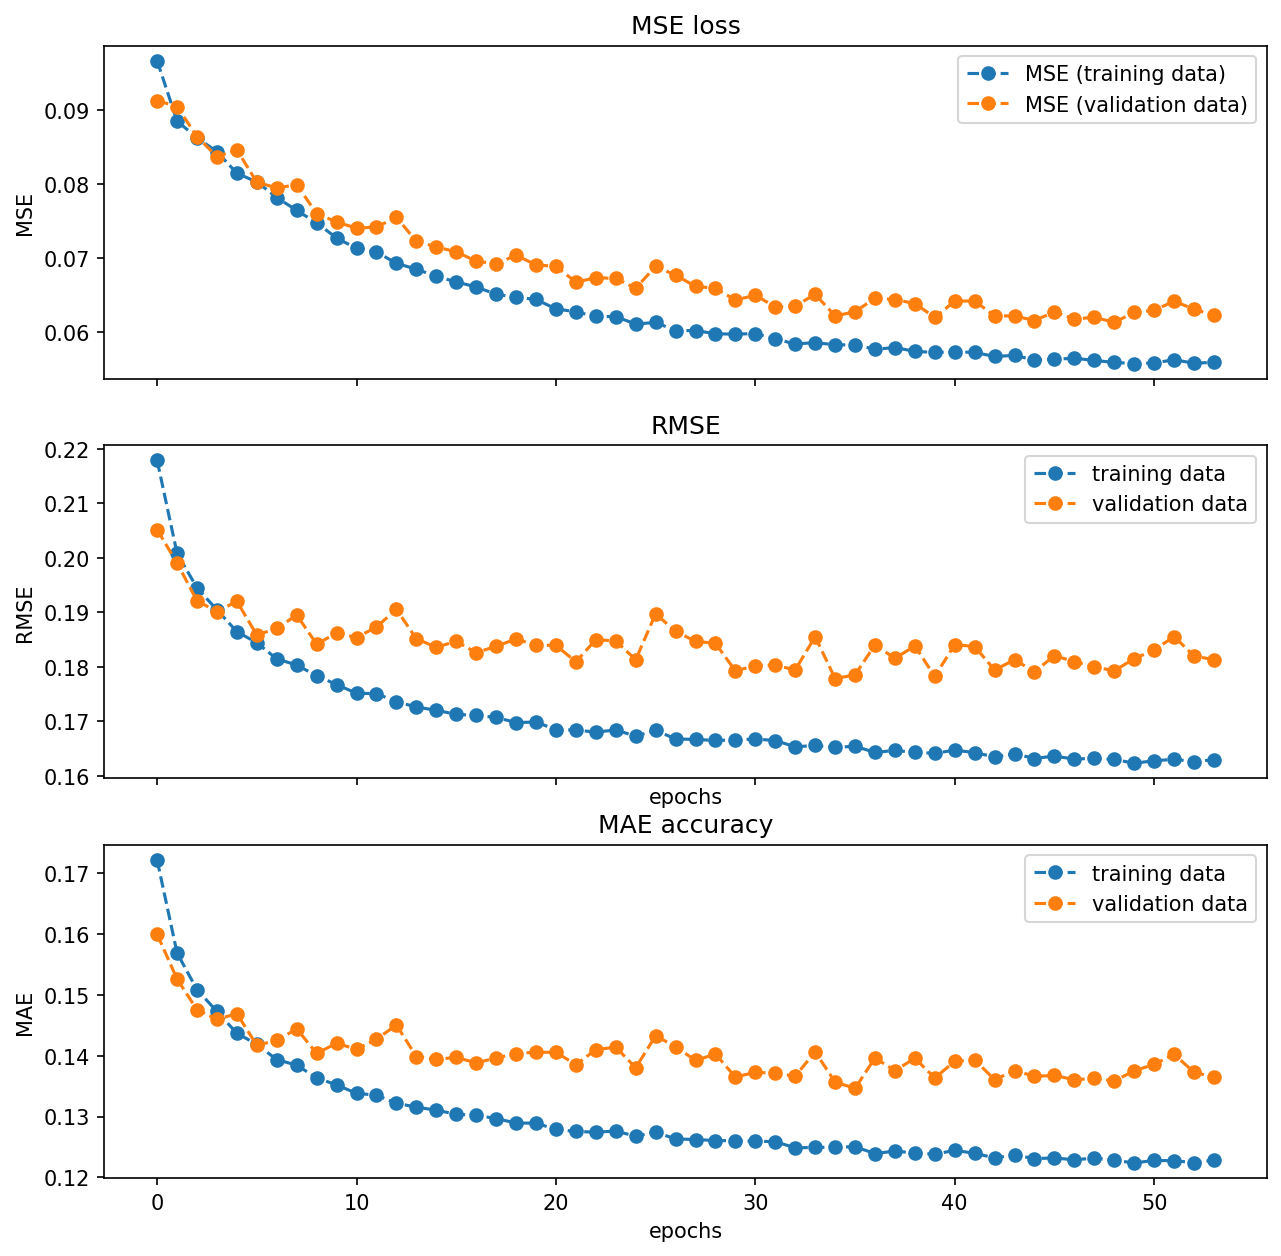

In [13]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(10,10), dpi=150)

ax1.plot(history['loss'], "o--", label='MSE (training data)')
ax1.plot(history['val_loss'], "o--", label='MSE (validation data)')
ax1.set_title('MSE loss')
ax1.set_ylabel("MSE")
ax1.legend()

ax2.plot(history['root_mean_squared_error'], "o--", label='training data')
ax2.plot(history['val_root_mean_squared_error'], "o--", label='validation data')
ax2.set_title('RMSE')
ax2.set_ylabel("RMSE")
ax2.set_xlabel("epochs")
ax2.legend()

ax3.plot(history['mae'], "o--", label='training data')
ax3.plot(history['val_mae'], "o--", label='validation data')
ax3.set_title('MAE accuracy')
ax3.set_ylabel("MAE")
ax3.set_xlabel("epochs")
ax3.legend()

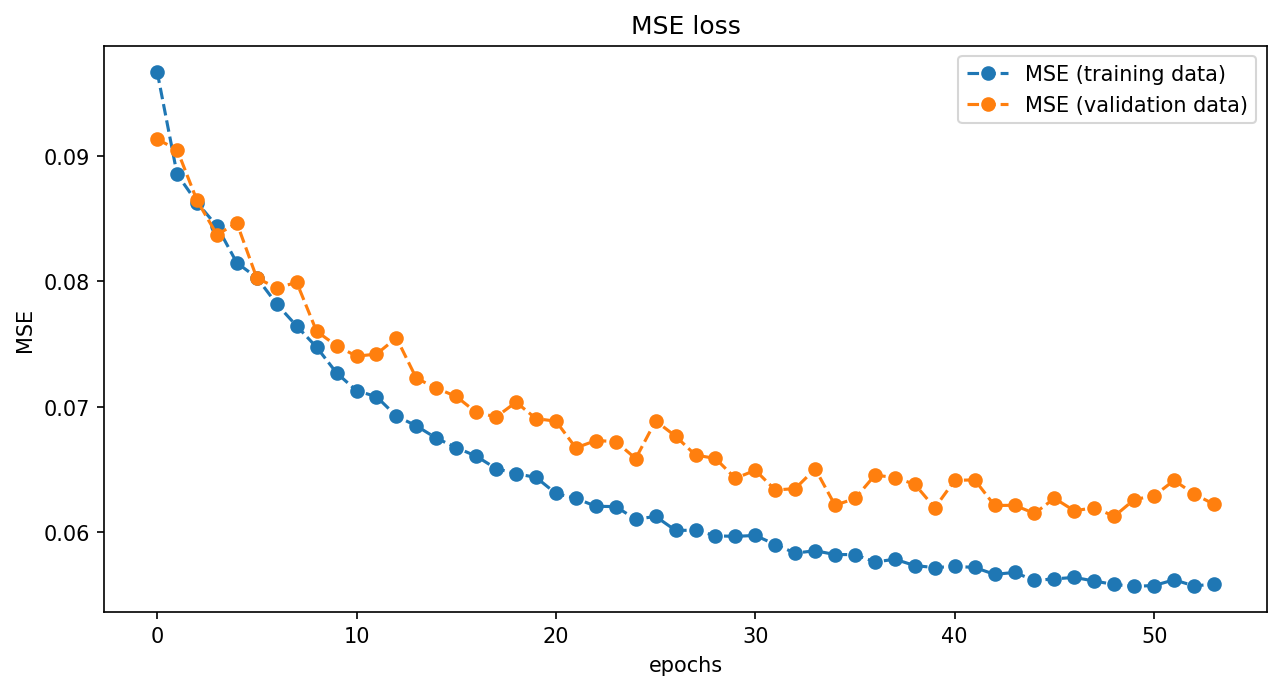

In [19]:
fig, ax1 = plt.subplots(1, 1, sharex=True, figsize=(10,5), dpi=150)

ax1.plot(history['loss'], "o--", label='MSE (training data)')
ax1.plot(history['val_loss'], "o--", label='MSE (validation data)')
ax1.set_title('MSE loss')
ax1.set_ylabel("MSE")
ax1.set_xlabel("epochs")
ax1.legend()
plt.savefig("20210326-191145_Test_10k_500_500_200_training_history.pdf")

## Predict Tanimoto scores

In [14]:
from ms2deepscore import MS2DeepScore
similarity_score = MS2DeepScore(model)

In [129]:
similarities_test = similarity_score.matrix(spectrums_test, spectrums_test, is_symmetric=True)

Calculating vectors of reference spectrums: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3601/3601 [05:35<00:00, 10.72it/s]


In [6]:
predictions_file = os.path.join(path_models, "trained_models", "predictions_test_20210326-191145_Test_10k_500_500_200.npy")
similarities_test = np.load(predictions_file)

In [15]:
inchikey_idx_test = np.zeros(len(spectrums_test))
for i, spec in enumerate(spectrums_test):
    inchikey_idx_test[i] = np.where(tanimoto_df.index.values == spec.get("inchikey")[:14])[0]

inchikey_idx_test = inchikey_idx_test.astype("int")

In [8]:
np.unique(inchikey_idx_test).shape

(500,)

In [9]:
scores_ref = tanimoto_df.values[np.ix_(inchikey_idx_test[:], inchikey_idx_test[:])].copy()

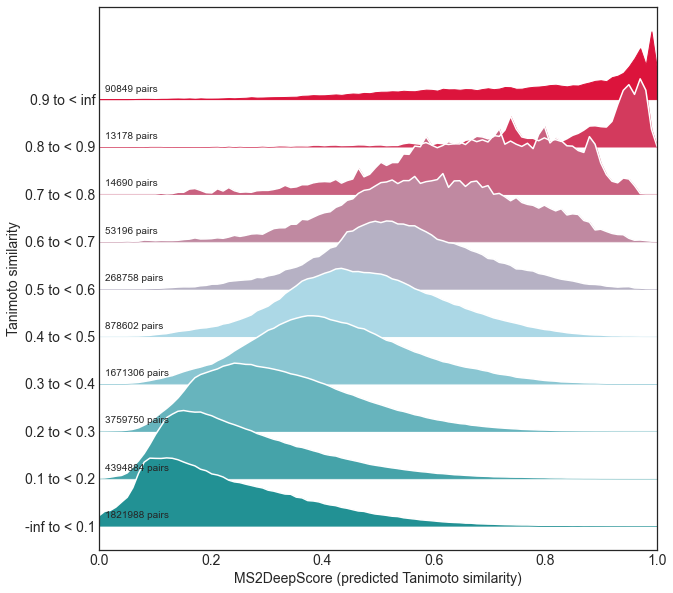

In [15]:
from ms2deepscore.plotting import create_histograms_plot

create_histograms_plot(scores_ref, similarities_test, n_bins=10, hist_resolution=100,
                          ref_score_name="Tanimoto similarity", compare_score_name="MS2DeepScore (predicted Tanimoto similarity)")

filename = os.path.join(path_models, "trained_models",
                        "histogram_20210326-191145_Test_10k_500_500_200_testset.svg")
plt.savefig(filename)

In [12]:
ref_score_bins = np.linspace(0,1.0, 11)
bin_content, bounds, rmses, maes = tanimoto_dependent_losses(similarities_test,
                                                             scores_ref, ref_score_bins)

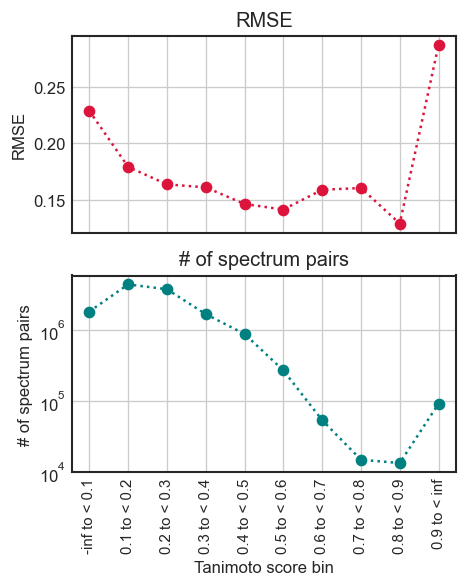

In [13]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(4, 5), dpi=120)

ax1.plot(np.arange(len(rmses)), rmses, "o:", color="crimson")
ax1.set_title('RMSE')
ax1.set_ylabel("RMSE")
ax1.grid(True)

ax2.plot(np.arange(len(rmses)), bin_content, "o:", color="teal")
ax2.set_title('# of spectrum pairs')
ax2.set_ylabel("# of spectrum pairs")
ax2.set_xlabel("Tanimoto score bin")
plt.yscale('log')
plt.xticks(np.arange(len(rmses)),
           [f"{a:.1f} to < {b:.1f}" for (a, b) in bounds], fontsize=9, rotation='vertical')
ax2.grid(True)
plt.tight_layout()

filename = os.path.join(path_models, "trained_models", "tanimoto_bin_evaluation_20210326-191145_Test_10k_500_500_200_testset.svg")
plt.savefig(filename)

# Check effect of parent mass and number of peaks

In [ ]:
numbers_of_peaks_test = np.array([len(s.peaks) for s in spectrums_test])
masses_test = np.array([s.get("parent_mass") for s in spectrums_test])

(3105,)


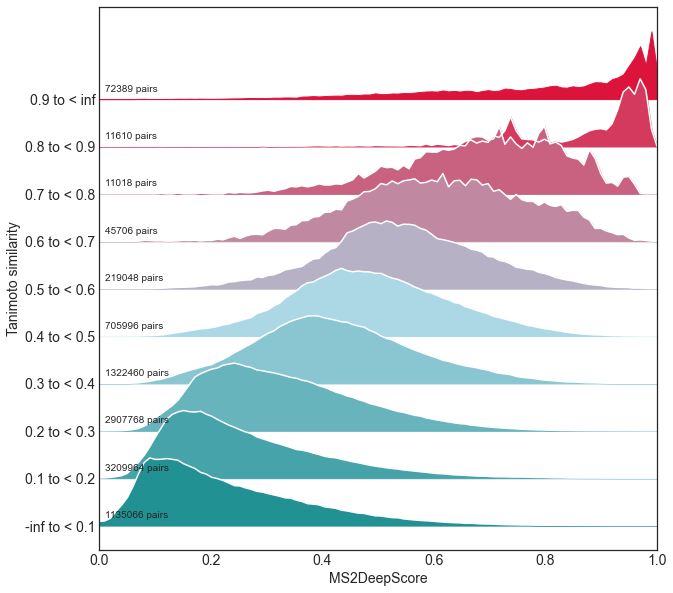

In [23]:
idx_peaks = np.where((numbers_of_peaks_test > 10) & (masses_test > 0))[0]
print(idx_peaks.shape)
idx =np.ix_(idx_peaks, idx_peaks)

create_histograms_plot(scores_ref[idx], similarities_test[idx], n_bins=10, hist_resolution=100,
                          ref_score_name="Tanimoto similarity", compare_score_name="MS2DeepScore")

In [25]:
ref_score_bins = np.linspace(0,1.0, 11)
bin_content_collection = []
rmses_collection = []
maes_collection = []
retrievals = []

for i, threshold in enumerate([0, 10, 20, 30, 50, 100]):
    print(f"Run evaluation no. {i} ----------------------------")
    idx_peaks = np.where(numbers_of_peaks_test > threshold)[0]
    idx =np.ix_(idx_peaks, idx_peaks)
    
    bin_content, bounds, rmses, maes = tanimoto_dependent_losses(similarities_test[idx],
                                                                 scores_ref[idx], ref_score_bins)
    bin_content_collection.append(bin_content)
    rmses_collection.append(rmses)
    maes_collection.append(maes)
    retrievals.append(idx[0].shape)

Run evaluation no. 0 ----------------------------
Run evaluation no. 1 ----------------------------
Run evaluation no. 2 ----------------------------
Run evaluation no. 3 ----------------------------
Run evaluation no. 4 ----------------------------
Run evaluation no. 5 ----------------------------


In [26]:
bin_content, bounds, rmses, maes = tanimoto_dependent_losses(similarities_test,
                                                             scores_ref, ref_score_bins)

Text(0.5, 0, 'Prediction accuracy within Tanimto score bins')

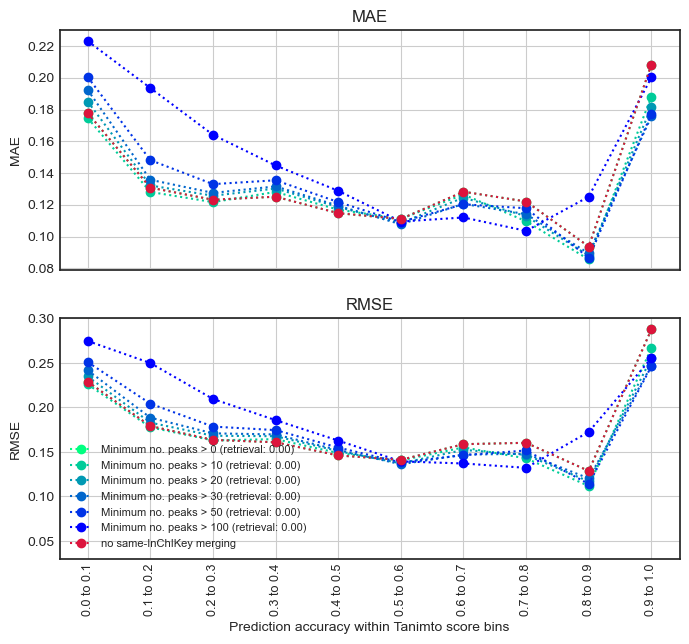

In [30]:
import matplotlib
cmap = matplotlib.cm.get_cmap('winter_r')

thresholds = [0, 10, 20, 30, 50, 100]
dim = similarities_test.shape[0]


bounds = [f"{a:.1f} to {a+0.1:.1f}" for a in ref_score_bins[:-1]]
labels = [f"Minimum no. peaks > {x} (retrieval: {(retrievals[i][0]/dim**2):.2f})" for i, x in enumerate(thresholds)]
#labels[-1] = "all"
N=len(labels)

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8, 7), dpi=100)
for i in range(N):
    ax1.plot(ref_score_bins[:-1], maes_collection[i], "o:", color=cmap(i/(N-1)), label=labels[i])
ax1.plot(ref_score_bins[:-1], maes, "o:", color="crimson", label="no same-InChIKey merging")
ax1.set_title('MAE')
ax1.set_ylabel("MAE")
#ax1.set_ylim(0)
ax1.grid(True)
#ax1.legend()

for i in range(N):
    ax2.plot(ref_score_bins[:-1], rmses_collection[i], "o:", color=cmap(i/(N-1)), label=labels[i])
ax2.plot(ref_score_bins[:-1], rmses, "o:", color="crimson", label="no same-InChIKey merging")
ax2.set_title('RMSE')
ax2.set_ylabel("RMSE")
ax2.set_ylim((0.03, 0.3))
ax2.grid(True)
ax2.legend(fontsize=8)
plt.xticks(ref_score_bins[:-1],
           bounds, fontsize=9, rotation='vertical')
plt.xlabel("Prediction accuracy within Tanimto score bins")
#plt.savefig("Number_of_peaks_20210326-191145_Test_10k_500_500_200.pdf")

---
## Compare same InChIKey spectra

In [31]:
inchikey_idx_test[:20]

array([ 9107,  2405,  2405,  2992,  2992,  2992,  4149,  4149,  4149,
        4149,  4149, 12831, 12831,  9107,  4909,  4909,  4909,  5057,
       13772,  4415])

In [16]:
from scipy.stats import iqr

inchikey_multiples = []
dim = similarities_test.shape[0]
#scores_inchikey_means = np.zeros((dim, dim))
#scores_inchikey_stds = np.zeros((dim, dim))
scores_inchikey_median = np.zeros((dim, dim))
scores_inchikey_iqr = np.zeros((dim, dim))
scores_inchikey_num = np.zeros((dim, dim))
for inchikeyID in np.unique(inchikey_idx_test):
    idx1 = np.where(inchikey_idx_test == inchikeyID)[0]
    inchikey_multiples.append(idx1.shape[0])
    for inchikeyID2 in np.unique(inchikey_idx_test):
        idx2 = np.where(inchikey_idx_test == inchikeyID2)[0]
        #scores_inchikey_means[np.ix_(idx1, idx2)] = similarities_test[np.ix_(idx1, idx2)].mean()
        scores_inchikey_median[np.ix_(idx1, idx2)] = np.median(similarities_test[np.ix_(idx1, idx2)])
        #scores_inchikey_stds[np.ix_(idx1, idx2)] = similarities_test[np.ix_(idx1, idx2)].std()
        scores_inchikey_iqr[np.ix_(idx1, idx2)] = iqr(similarities_test[np.ix_(idx1, idx2)])
        scores_inchikey_num[np.ix_(idx1, idx2)] = idx1.shape[0] * idx2.shape[0]

In [193]:
"""OLDinchikey_multiples = []
dim = similarities_test.shape[0]
scores_inchikey_means = np.zeros((dim, dim))
scores_inchikey_stds = np.zeros((dim, dim))
scores_inchikey_num = np.zeros((dim, dim))

for inchikeyID in np.unique(inchikey_idx_test):
    idx = np.where(inchikey_idx_test == inchikeyID)[0]
    inchikey_multiples.append(idx.shape[0])
    scores_inchikey_means[:, idx] = np.tile(similarities_test[:, idx].mean(axis=1), (idx.shape[0], 1)).T
    scores_inchikey_stds[:, idx] = np.tile(similarities_test[:, idx].std(axis=1), (idx.shape[0], 1)).T
    scores_inchikey_num[:, idx] = idx.shape[0]

scores_inchikey_stds[scores_inchikey_stds==0] = 0
""""""

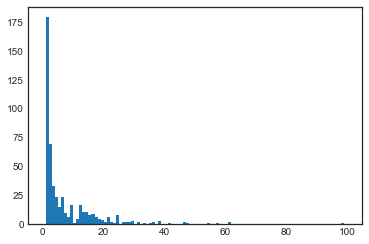

In [249]:
a = plt.hist(inchikey_multiples, np.linspace(0, 100, 101))

In [264]:
scores_inchikey_stds.min(), scores_inchikey_stds.max(), scores_inchikey_stds.mean()

(0.0, 0.44168783599452976, 0.08251088204599438)

In [209]:
scores_inchikey_stds[scores_inchikey_stds==0]

array([], dtype=float64)

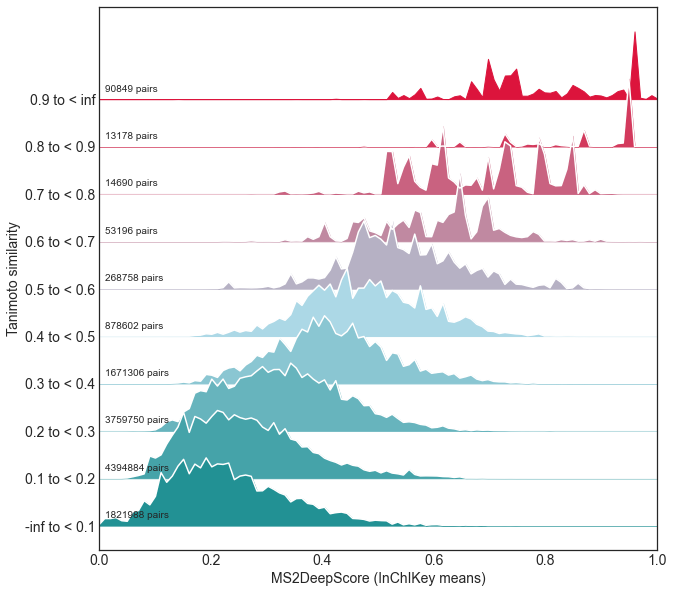

In [34]:
from ms2deepscore.plotting import create_histograms_plot

create_histograms_plot(scores_ref, scores_inchikey_means, n_bins=10, hist_resolution=100,
                       ref_score_name="Tanimoto similarity", compare_score_name="MS2DeepScore (InChIKey means)")

#filename = os.path.join(path_models, "trained_models",
#                        "histogram_20210326-191145_Test_10k_500_500_200_testset.pdf")
#plt.savefig(filename)

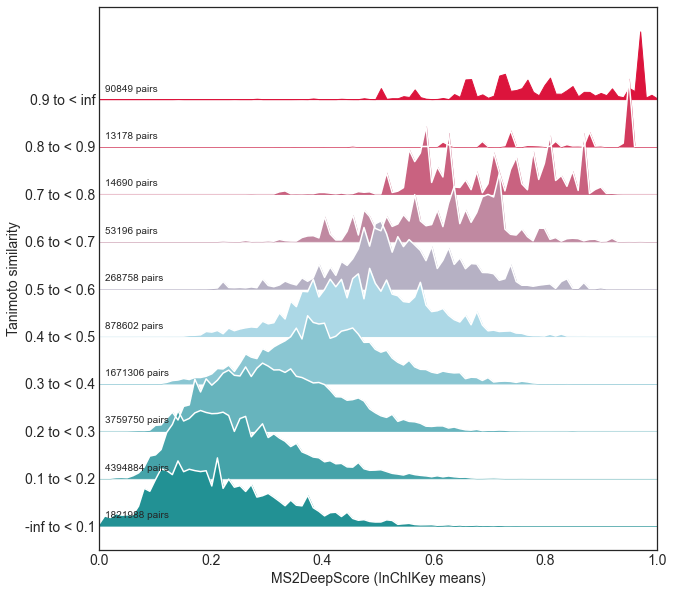

In [37]:
create_histograms_plot(scores_ref, scores_inchikey_median, n_bins=10, hist_resolution=100,
                       ref_score_name="Tanimoto similarity", compare_score_name="MS2DeepScore (InChIKey means)")

In [38]:
bin_content, bounds, rmses, maes = tanimoto_dependent_losses(scores_inchikey_median,
                                                             scores_ref, ref_score_bins)

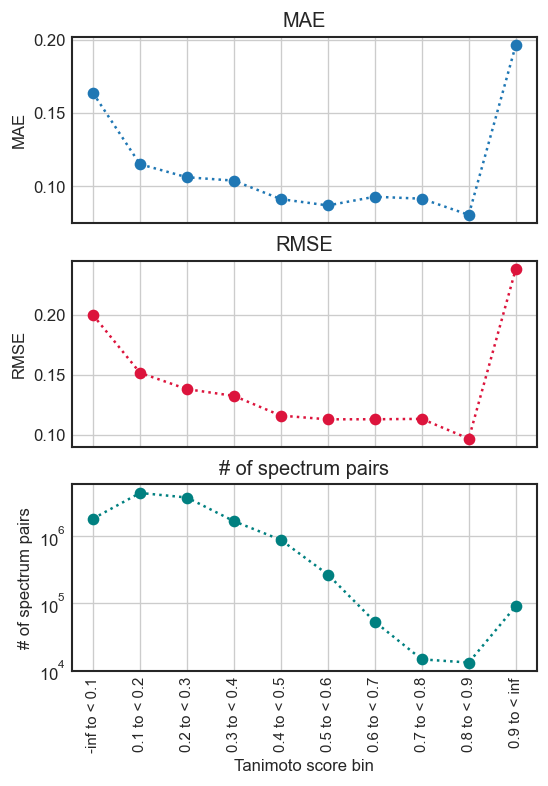

In [39]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(5, 7), dpi=120)
ax1.plot(np.arange(len(rmses)), maes, "o:")
ax1.set_title('MAE')
ax1.set_ylabel("MAE")
#ax1.set_ylim(0)
ax1.grid(True)

ax2.plot(np.arange(len(rmses)), rmses, "o:", color="crimson")
ax2.set_title('RMSE')
ax2.set_ylabel("RMSE")
ax2.grid(True)

ax3.plot(np.arange(len(rmses)), bin_content, "o:", color="teal")
ax3.set_title('# of spectrum pairs')
ax3.set_ylabel("# of spectrum pairs")
ax3.set_xlabel("Tanimoto score bin")
plt.yscale('log')
plt.xticks(np.arange(len(rmses)),
           [f"{a:.1f} to < {b:.1f}" for (a, b) in bounds], fontsize=9, rotation='vertical')
ax3.grid(True)


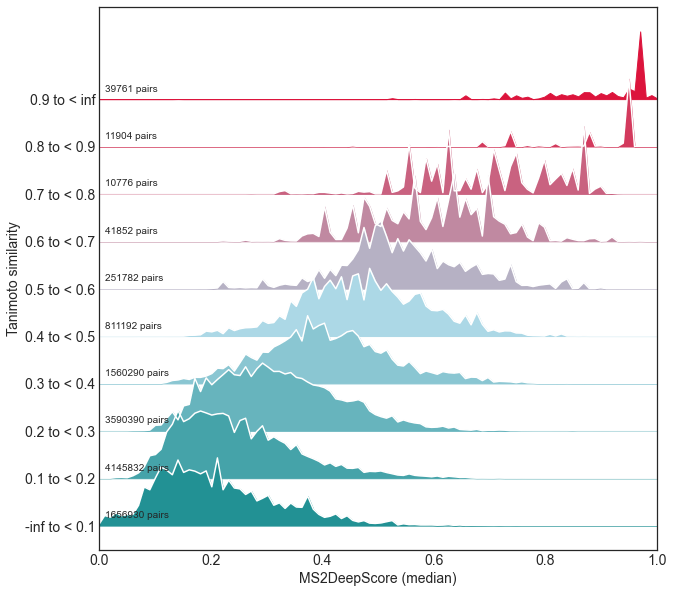

In [18]:
idx = np.where(scores_inchikey_iqr < 0.2)
create_histograms_plot(scores_ref[idx], scores_inchikey_median[idx], n_bins=10, hist_resolution=100,
                       ref_score_name="Tanimoto similarity", compare_score_name="MS2DeepScore (median)")

filename = os.path.join(path_models, "trained_models",
                        "histogram_InchikeyMerging_IQR_02_20210326-191145_Test_10k_500_500_200_testset.svg")
plt.savefig(filename)

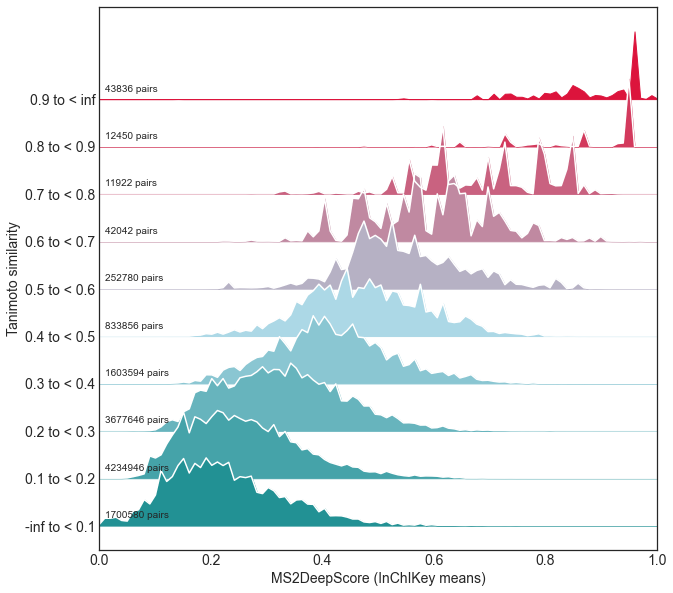

In [274]:
idx = np.where(scores_inchikey_iqr < 0.15)
create_histograms_plot(scores_ref[idx], scores_inchikey_means[idx], n_bins=10, hist_resolution=100,
                       ref_score_name="Tanimoto similarity", compare_score_name="MS2DeepScore (InChIKey means)")

filename = os.path.join(path_models, "trained_models",
                        "histogram_InchikeyMerging_20210326-191145_Test_10k_500_500_200_testset.pdf")
plt.savefig(filename)

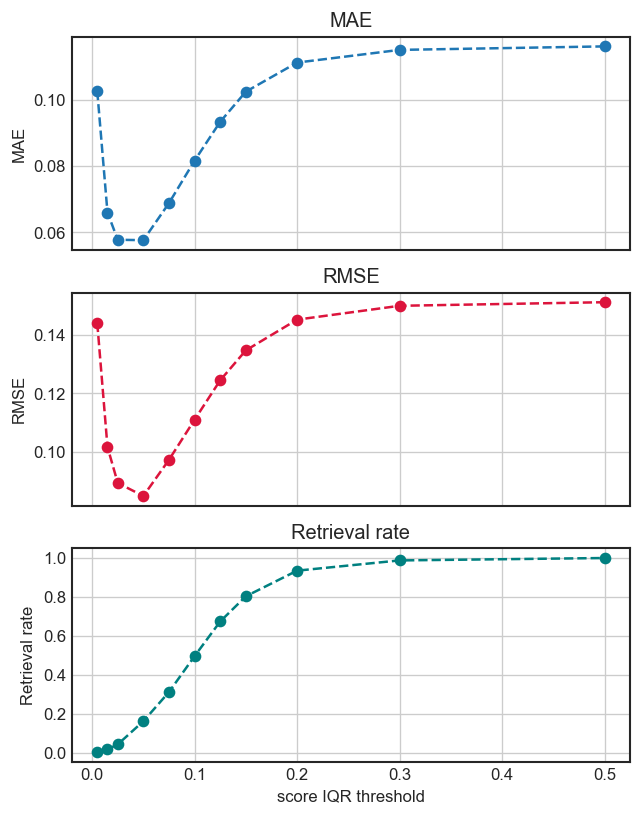

In [47]:
maes, rmses, recall = evaluate_ensemble_loss(scores_inchikey_median, scores_inchikey_iqr, scores_ref,
                       std_thresholds = [0.005, 0.015, 0.025, 0.05, 0.075, 0.1, 0.125, 0.15, 0.2, 0.3, 0.5])

#plt.savefig("similarities_.....pdf")

In [19]:
ref_score_bins = np.linspace(0,1.0, 11)
bin_content_collection = []
rmses_collection = []
maes_collection = []
retrievals = []

for i, threshold in enumerate([0.06, 0.1, 0.15, 0.2, np.inf]):
    print(f"Run evaluation no. {i} ----------------------------")
    idx = np.where(scores_inchikey_iqr < threshold)
    
    bin_content, bounds, rmses, maes = tanimoto_dependent_losses(scores_inchikey_median[idx],
                                                                 scores_ref[idx], ref_score_bins)
    bin_content_collection.append(bin_content)
    rmses_collection.append(rmses)
    maes_collection.append(maes)
    retrievals.append(idx[0].shape)

Run evaluation no. 0 ----------------------------
Run evaluation no. 1 ----------------------------
Run evaluation no. 2 ----------------------------
Run evaluation no. 3 ----------------------------
Run evaluation no. 4 ----------------------------


In [20]:
bin_content, bounds, rmses, maes = tanimoto_dependent_losses(similarities_test,
                                                             scores_ref, ref_score_bins)

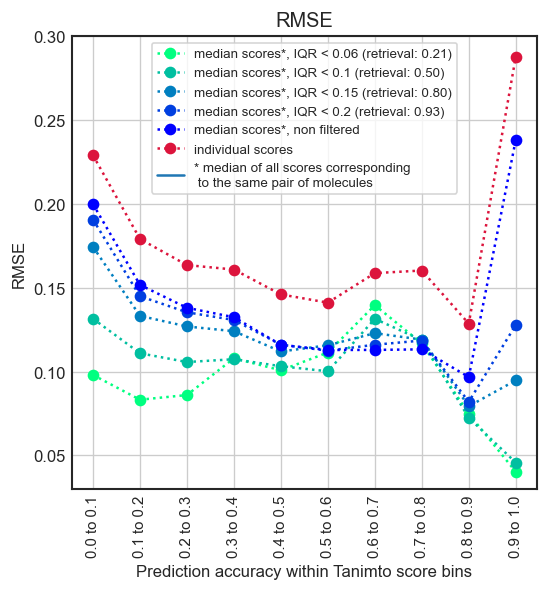

In [26]:
import matplotlib
cmap = matplotlib.cm.get_cmap('winter_r')

thresholds = [0.06, 0.1, 0.15, 0.2, np.inf]

bounds = [f"{a:.1f} to {a+0.1:.1f}" for a in ref_score_bins[:-1]]
labels = [f"median scores*, IQR < {x} (retrieval: {(retrievals[i][0]/dim**2):.2f})" for i, x in enumerate(thresholds)]
labels[-1] = "median scores*, non filtered"
N=len(labels)

plt.figure(figsize=(5,5), dpi=120)
for i in range(N):
    plt.plot(ref_score_bins[:-1], rmses_collection[i], "o:", color=cmap(i/(N-1)), label=labels[i])
plt.plot(ref_score_bins[:-1], rmses, "o:", color="crimson", label="individual scores")
plt.plot([], [], label="* median of all scores corresponding \n to the same pair of molecules")
plt.title('RMSE')
plt.ylabel("RMSE")
plt.ylim((0.03, 0.3))
plt.grid(True)
plt.legend(fontsize=8, frameon=True, facecolor="white")
plt.xticks(ref_score_bins[:-1],
           bounds, fontsize=9, rotation='vertical')
plt.xlabel("Prediction accuracy within Tanimto score bins")

filename = os.path.join(path_models, "trained_models",
                        "Inchikey_merging_IQR_20210326-191145_Test_10k_500_500_200.svg")   
plt.savefig(filename)

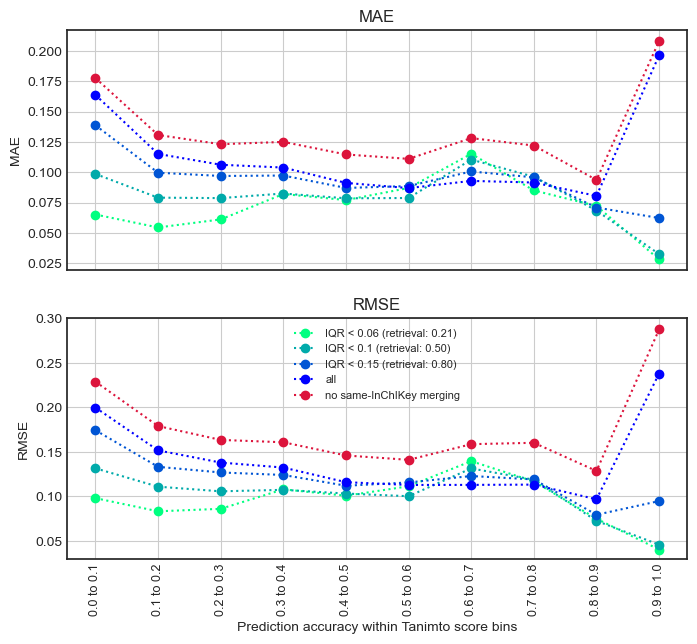

In [57]:
import matplotlib
cmap = matplotlib.cm.get_cmap('winter_r')

thresholds = [0.06, 0.1, 0.15, np.inf]

bounds = [f"{a:.1f} to {a+0.1:.1f}" for a in ref_score_bins[:-1]]
labels = [f"IQR < {x} (retrieval: {(retrievals[i][0]/dim**2):.2f})" for i, x in enumerate(thresholds)]
labels[-1] = "all"
N=len(labels)

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8, 7), dpi=100)
for i in range(N):
    ax1.plot(ref_score_bins[:-1], maes_collection[i], "o:", color=cmap(i/(N-1)), label=labels[i])
ax1.plot(ref_score_bins[:-1], maes, "o:", color="crimson", label="no same-InChIKey merging")
ax1.set_title('MAE')
ax1.set_ylabel("MAE")
#ax1.set_ylim(0)
ax1.grid(True)
#ax1.legend()

for i in range(N):
    ax2.plot(ref_score_bins[:-1], rmses_collection[i], "o:", color=cmap(i/(N-1)), label=labels[i])
ax2.plot(ref_score_bins[:-1], rmses, "o:", color="crimson", label="no same-InChIKey merging")
ax2.set_title('RMSE')
ax2.set_ylabel("RMSE")
ax2.set_ylim((0.03, 0.3))
ax2.grid(True)
ax2.legend(fontsize=8)
plt.xticks(ref_score_bins[:-1],
           bounds, fontsize=9, rotation='vertical')
plt.xlabel("Prediction accuracy within Tanimto score bins")
plt.savefig("Inchikey_merging_IQR_20210326-191145_Test_10k_500_500_200.pdf")

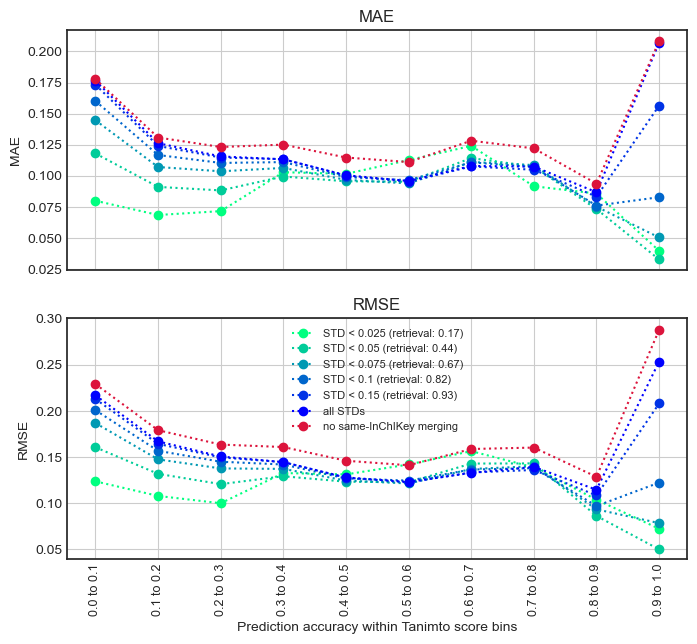

In [243]:
import matplotlib
cmap = matplotlib.cm.get_cmap('winter_r')

bounds = [f"{a:.1f} to {a+0.1:.1f}" for a in ref_score_bins[:-1]]
labels = [f"STD < {x} (retrieval: {(retrievals[i][0]/dim**2):.2f})" for i, x in enumerate([0.025, 0.05, 0.075, 0.1, 0.15, np.inf])]
labels[-1] = "all STDs"
N=len(labels)

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8, 7), dpi=100)
for i in range(N):
    ax1.plot(ref_score_bins[:-1], maes_collection[i], "o:", color=cmap(i/(N-1)), label=labels[i])
ax1.plot(ref_score_bins[:-1], maes, "o:", color="crimson", label="no same-InChIKey merging")
ax1.set_title('MAE')
ax1.set_ylabel("MAE")
#ax1.set_ylim(0)
ax1.grid(True)
#ax1.legend()

for i in range(N):
    ax2.plot(ref_score_bins[:-1], rmses_collection[i], "o:", color=cmap(i/(N-1)), label=labels[i])
ax2.plot(ref_score_bins[:-1], rmses, "o:", color="crimson", label="no same-InChIKey merging")
ax2.set_title('RMSE')
ax2.set_ylabel("RMSE")
ax2.set_ylim((0.04, 0.3))
ax2.grid(True)
ax2.legend(fontsize=8)
plt.xticks(ref_score_bins[:-1],
           bounds, fontsize=9, rotation='vertical')
plt.xlabel("Prediction accuracy within Tanimto score bins")
plt.savefig("Inchikey_merging_20210326-191145_Test_10k_500_500_200.pdf")


---
# Predict Tanimoto scores (Monte Carlo dropout)

In [6]:
def evaluate_ensemble_loss(scores, scores_std, scores_ref, std_thresholds, xlabel="score IQR threshold"):
    plt.style.use('seaborn-white')
    maes = []
    rmses = []
    recall = []
    total_scores = scores.shape[0] * scores.shape[1]
    for thres in std_thresholds:
        idx = np.where(scores_std < thres)
        recall.append(idx[0].shape[0]/total_scores)
        maes.append(np.abs(scores_ref[idx] - scores[idx]).mean())
        rmses.append(np.sqrt(np.square(scores_ref[idx] - scores[idx]).mean()))

    fig, (ax2, ax3) = plt.subplots(2, 1, sharex=True, figsize=(6, 7), dpi=120)
    """ax1.plot(std_thresholds, maes, "o--")
    ax1.set_title('MAE')
    ax1.set_ylabel("MAE")
    #ax1.set_ylim(0.04)
    ax1.grid(True)"""
    
    ax2.plot(std_thresholds, rmses, "o--", color="crimson")
    ax2.set_title('RMSE')
    ax2.set_ylabel("RMSE")
    #ax2.set_xlabel("score STD threshold")
    #ax2.set_ylim(0.06)
    ax2.grid(True)

    ax3.plot(std_thresholds, recall, "o--", color="teal")
    ax3.set_title('Retrieval rate')
    ax3.set_ylabel("Retrieval rate")
    ax3.set_xlabel(xlabel)
    #ax3.set_ylim(0)
    ax3.grid(True)
    
    return maes, rmses, recall

## Model (20210326-191145_Test_10k_500_500_200.hdf5)

In [7]:
# import spectrum binner
binner_file = os.path.join(path_data, 'GNPS_all',
                           'ALL_GNPS_positive_training_spectrum_binner_210301_10k.pickle')
with open(binner_file, 'rb') as file:
    spectrum_binner = pickle.load(file)

In [8]:
import tensorflow as tf
from tensorflow.keras.models import load_model as load_keras_model
keras_model_file = os.path.join(path_models, "trained_models", "20210326-191145_Test_10k_500_500_200.hdf5")
keras_model = load_keras_model(keras_model_file)

### Create SiameseModel from model and spectrum_binner

In [9]:
model = SiameseModel(spectrum_binner, keras_model=keras_model)

### Compute similarity scores

In [9]:
from ms2deepscore import MS2DeepScoreMonteCarlo
similarity_score_mc = MS2DeepScoreMonteCarlo(model, n_ensembles=10, average_type='median')

In [10]:
similarities_test_mc = similarity_score_mc.matrix(spectrums_test, spectrums_test, is_symmetric=True)

Calculating vectors of reference spectrums: 100%|██████████████████████████████████████████████████████████████████████████| 3601/3601 [09:35<00:00,  6.26it/s]


### Alternative (e.g. for re-running notebooks): load precomputed similarities

In [10]:
filename = os.path.join(path_data, "predictions_test_MC_medianIQR_20210326-191145_Test_10k_500_500_200.npy")
#np.save(filename, similarities_test_mc)
similarities_test_mc = np.load(filename)

In [11]:
similarities_test_mc['uncertainty'].mean(), np.median(similarities_test_mc['uncertainty']), similarities_test_mc['uncertainty'].min(), similarities_test_mc['uncertainty'].max()

(0.032071832516001375,
 0.031024274893611092,
 0.0032546784299799644,
 0.17188690046046)

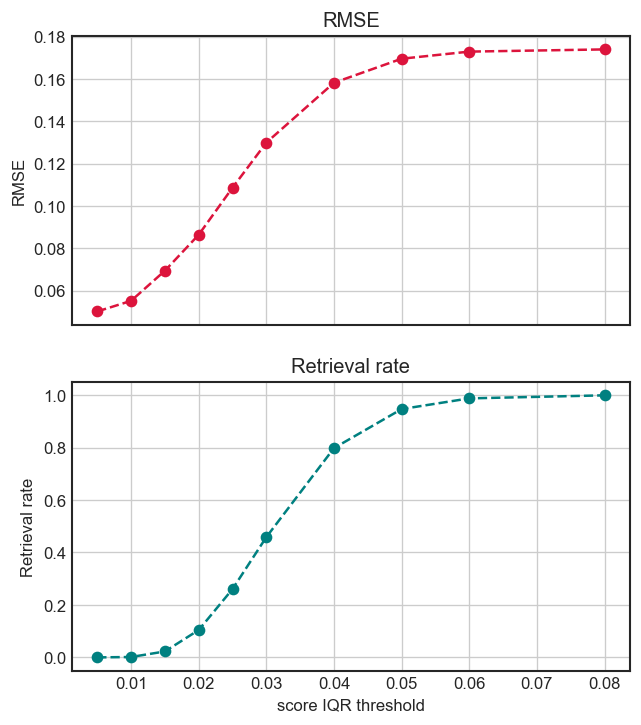

In [82]:
maes, rmses, recall = evaluate_ensemble_loss(similarities_test_mc['score'], similarities_test_mc['uncertainty'], scores_ref,
                      std_thresholds = [0.005, 0.01, 0.015, 0.02, 0.025, 0.03, 0.04, 0.05, 0.06, 0.08])#, 0.2, 0.25])

#plt.savefig("similarities_20210326-191145_Test_10k_500_500_200_MC_medianIQR.pdf")

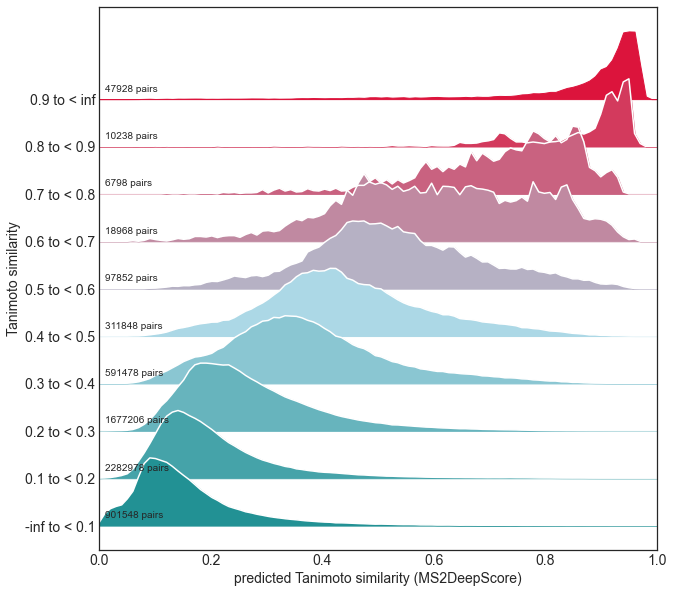

In [26]:
from ms2deepscore.plotting import create_histograms_plot

idx = np.where(similarities_test_mc['uncertainty'] < 0.03)
create_histograms_plot(scores_ref[idx], similarities_test_mc['score'][idx], n_bins=10, hist_resolution=100,
                       ref_score_name="Tanimoto similarity", compare_score_name="predicted Tanimoto similarity (MS2DeepScore)")

In [76]:
dim = similarities_test_mc['score'].shape[0]

In [65]:
ref_score_bins = np.linspace(0,1.0, 11)
bin_content_collection = []
rmses_collection = []
maes_collection = []
retrievals = []
dim = similarities_test_mc['score'].shape[0]

for i, threshold in enumerate([0.025, 0.03, 0.04, np.inf]):
    print(f"Run evaluation no. {i} ----------------------------")
    idx = np.where(similarities_test_mc['uncertainty'] < threshold)
    retrievals.append(idx[0].shape[0])
    
    bin_content, bounds, rmses, maes = tanimoto_dependent_losses(similarities_test_mc['score'][idx],
                                                                 scores_ref[idx], ref_score_bins)
    bin_content_collection.append(bin_content)
    rmses_collection.append(rmses)
    maes_collection.append(maes)

Run evaluation no. 0 ----------------------------
Run evaluation no. 1 ----------------------------
Run evaluation no. 2 ----------------------------
Run evaluation no. 3 ----------------------------


In [66]:
#predictions_file = os.path.join(path_models, "trained_models", "predictions_test_20210326-191145_Test_10k_500_500_200.npy")
#similarities_test = np.load(predictions_file)
bin_content, bounds, rmses, maes = tanimoto_dependent_losses(similarities_test,
                                                             scores_ref, ref_score_bins)

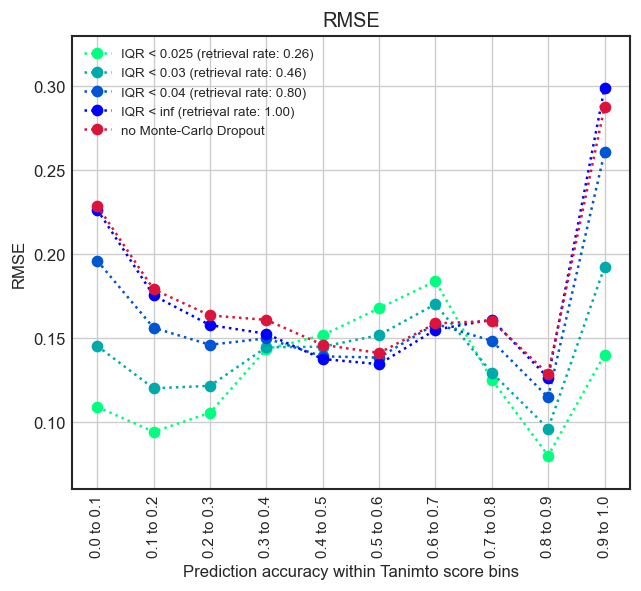

In [80]:
import matplotlib
cmap = matplotlib.cm.get_cmap('winter_r')

bounds = [f"{a:.1f} to {a+0.1:.1f}" for a in ref_score_bins[:-1]]
labels = [f"IQR < {x} (retrieval rate: {(retrievals[i]/dim**2):.2f})" for i, x in enumerate([0.025, 0.03, 0.04, np.inf])]
N=len(labels)

fig, ax2 = plt.subplots(1, 1, sharex=True, figsize=(6, 5), dpi=120)
"""for i in range(N):
    ax1.plot(ref_score_bins[:-1], maes_collection[i], "o:", color=cmap(i/(N-1)), label=labels[i])
ax1.plot(ref_score_bins[:-1], maes, "o:", color='crimson', label="no Monte-Carlo Dropout")
ax1.set_title('MAE')
ax1.set_ylabel("MAE")
ax1.set_ylim(0.05)
ax1.grid(True)
ax1.legend()"""

for i in range(N):
    ax2.plot(ref_score_bins[:-1], rmses_collection[i], "o:", color=cmap(i/(N-1)), label=labels[i])
ax2.plot(ref_score_bins[:-1], rmses, "o:", color='crimson', label="no Monte-Carlo Dropout")  
ax2.set_title('RMSE')
ax2.set_ylabel("RMSE")
ax2.set_ylim((0.06, 0.33))
ax2.grid(True)
ax2.legend(fontsize=8)
plt.xticks(ref_score_bins[:-1],
           bounds, fontsize=9, rotation='vertical')
plt.xlabel("Prediction accuracy within Tanimto score bins")
plt.savefig("Monte_Carlo_dropout_medianIQR_20210326-191145_Test_10k_500_500_200.pdf")

## Additional supplementary figure (request of reviewer)

In [12]:
similarities_test_mc['uncertainty'].shape

(3601, 3601)

In [ ]:
scores_ref = tanimoto_df.values[np.ix_(inchikey_idx_test[:], inchikey_idx_test[:])].copy()

In [25]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap


def create_histograms_plot(reference_scores, comparison_scores, n_bins=10, hist_resolution=100,
                          ref_score_name="Tanimoto similarity", compare_score_name="MS2DeepScore",
                          max_score=1, max_score_ref=1):
    """
    Plot histograms to compare reference and comparison scores.

    Parameters
    ----------
    reference_scores
        Reference score array.
    comparison_scores
        Comparison score array.
    n_bins
        Number of bins. The default is 5.
    hist_resolution
        Histogram resolution. The default is 100.
    ref_score_name
        Label string. The default is "Tanimoto similarity".
    compare_score_name
        Label string. The default is "MS2DeepScore".

    """
    # pylint: disable=too-many-arguments
    histograms, used_bins, bin_content = calculate_histograms(reference_scores, comparison_scores,
                                                              n_bins, hist_resolution,
                                                              max_score, max_score_ref)

    plot_histograms(histograms, used_bins, bin_content,
                    xlabel=compare_score_name, ylabel=ref_score_name,
                    max_score=max_score)


def plot_histograms(histograms, y_score_bins, bin_content=None,
                    xlabel="MS2DeepScore", ylabel="Tanimoto similarity",
                    max_score=1):
    """Create histogram based score comparison.
    """

    # Setup plotting stuff
    colors = ["crimson", "lightblue", "teal"]
    cmap1 = LinearSegmentedColormap.from_list("mycmap", colors)
    plt.style.use('seaborn-white')
    shift = 0.7
    alpha = 1.0 #0.5

    # Create plot
    plt.figure(figsize=(10,10))

    for i in range(0, len(histograms)):
        data = histograms[len(histograms)-i-1][0]
        data = data/max(data)
        plt.fill_between(histograms[0][1][:100], -shift*i, [(-shift*i + x) for x in data], color=cmap1(i/10), alpha=alpha)
        if i > 0:
            plt.plot(histograms[0][1][:100], [(-shift*i + x) for x in data], color="white")
        if bin_content:
            plt.text(0.01, -shift*i+shift/6, f"{bin_content[::-1][i]} pairs")#, color="white")

    plt.xticks(fontsize=14)
    plt.yticks(-shift*np.arange(len(histograms)),
               [f"{a:.1f} to < {b:.1f}" for (a, b) in y_score_bins[::-1]], fontsize=14)
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    plt.xlim([0, max_score])


def calculate_histograms(reference_scores, comparison_scores,
                         n_bins=10, hist_resolution=100, max_score=1, max_score_ref=1):
    """Calcualte a series of histograms, one for every bin."""
    hist_bins = np.linspace(0, max_score, hist_resolution)
    hist_bins = np.concatenate((hist_bins, np.array([2.0])))

    histograms = []
    used_bins = []
    bin_content = []
    ref_scores_bins_inclusive = np.linspace(0, max_score_ref, n_bins+1)
    ref_scores_bins_inclusive[0] = -np.inf
    ref_scores_bins_inclusive[-1] = np.inf
    
    for i in range(n_bins):
        used_bins.append((ref_scores_bins_inclusive[i], ref_scores_bins_inclusive[i+1]))
        idx = np.where((reference_scores >= ref_scores_bins_inclusive[i]) & (reference_scores < ref_scores_bins_inclusive[i+1]))
        bin_content.append(idx[0].shape[0])
        a, b = np.histogram(comparison_scores[idx], bins=hist_bins)
        histograms.append((a, b))

    return histograms, used_bins, bin_content



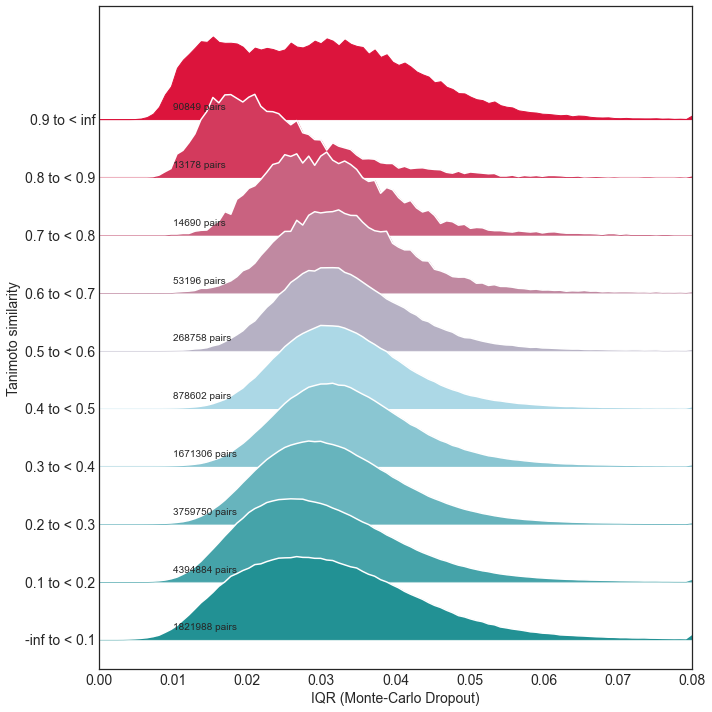

In [75]:
#from ms2deepscore.plotting import create_histograms_plot

create_histograms_plot(scores_ref, similarities_test_mc['uncertainty'], n_bins=10, hist_resolution=100,
                       ref_score_name="Tanimoto similarity", compare_score_name="IQR (Monte-Carlo Dropout)",
                       max_score=0.08, max_score_ref=1)
plt.tight_layout()
plt.savefig("supplemental_IQR_distribution_vs_Tanimoto_bins.pdf")
plt.savefig("supplemental_IQR_distribution_vs_Tanimoto_bins.svg")

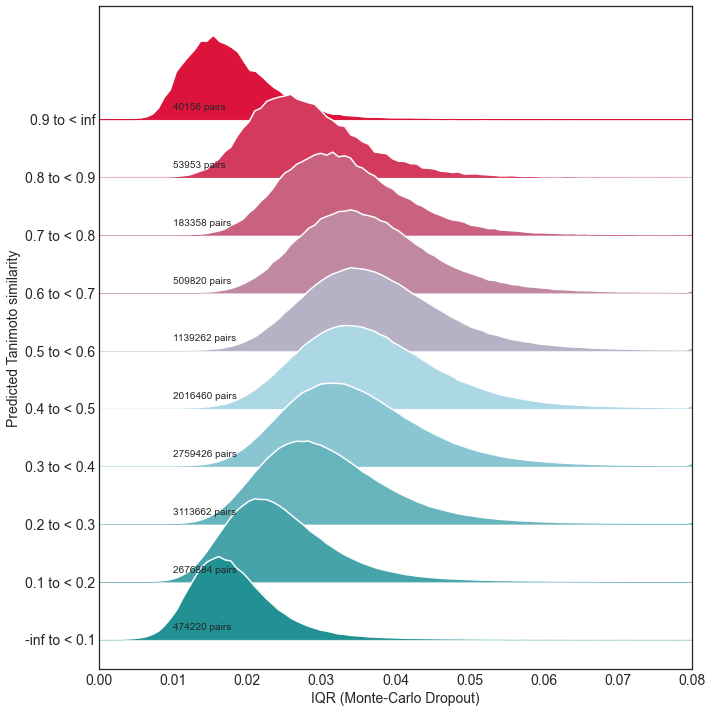

In [74]:
create_histograms_plot(similarities_test_mc['score'], similarities_test_mc['uncertainty'],
                       n_bins=10, hist_resolution=100,
                       ref_score_name="Predicted Tanimoto similarity", compare_score_name="IQR (Monte-Carlo Dropout)",
                       max_score=0.08, max_score_ref=1)
plt.tight_layout()
plt.savefig("supplemental_IQR_distribution_vs_predicted_Tanimoto_bins.pdf")
plt.savefig("supplemental_IQR_distribution_vs_predicted_Tanimoto_bins.svg")

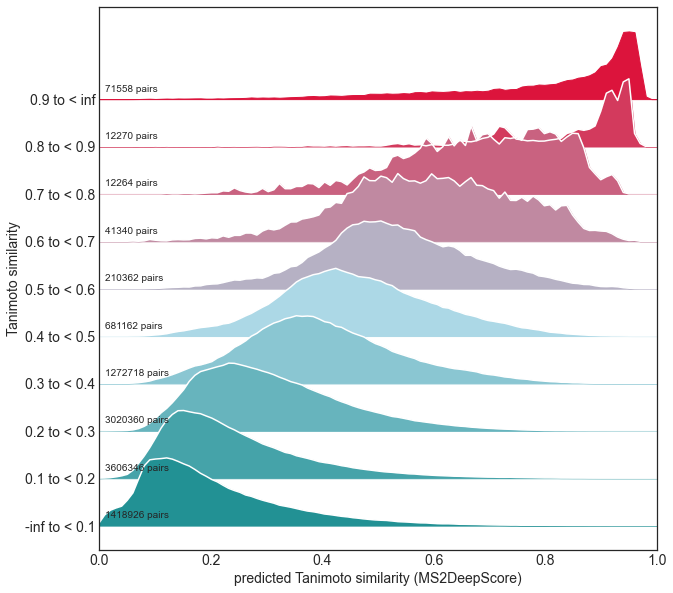

In [32]:
idx = np.where(similarities_test_mc['uncertainty'] < 0.04)
create_histograms_plot(scores_ref[idx], similarities_test_mc['score'][idx], n_bins=10, hist_resolution=100,
                       ref_score_name="Tanimoto similarity", compare_score_name="predicted Tanimoto similarity (MS2DeepScore)")

## Possible future improvements along those lines:

In [70]:
ref_score_bins = np.linspace(0,1.0, 11)

def get_percentiles(scores, IQRs, ref_score_bins, percentile=80):
    percentiles = []
    bounds = []
    ref_scores_bins_inclusive = open_up_bins(ref_score_bins)
    for i in range(len(ref_scores_bins_inclusive)-1):
        low = ref_scores_bins_inclusive[i]
        high = ref_scores_bins_inclusive[i+1]
        bounds.append((low, high))
        idx = np.where((scores >= low) & (scores < high))

        percentiles.append(np.percentile(IQRs[idx], percentile))
        
    return percentiles

def get_idx_in_percentile(scores, IQRs, ref_score_bins, percentile=80):
    percentiles = get_percentiles(similarities_test_mc['score'],
                                  similarities_test_mc['uncertainty'],
                                  ref_score_bins, percentile=percentile)
    
    ref_scores_bins_inclusive = open_up_bins(ref_score_bins)
    idx_all = [np.zeros(0).astype(int), np.zeros(0).astype(int)]
    for i in range(len(ref_scores_bins_inclusive)-1):
        low = ref_scores_bins_inclusive[i]
        high = ref_scores_bins_inclusive[i+1]
        idx = np.where((scores >= low) & (scores < high) & (IQRs < percentiles[i]))
        idx_all[0] = np.concatenate((idx_all[0], idx[0]))
        idx_all[1] = np.concatenate((idx_all[1], idx[1]))
    return idx_all

        
def open_up_bins(bins):
    bins_new = bins.copy()
    bins_new[0] = -np.inf
    bins_new[-1] = np.inf
    return bins_new

In [37]:
percentiles = get_percentiles(similarities_test_mc['score'], similarities_test_mc['uncertainty'],
                              ref_score_bins)

In [45]:
percentiles

[0.02292985461179181,
 0.030534046758214695,
 0.037878528648782495,
 0.04239222080746913,
 0.0444881898487494,
 0.04497789793202012,
 0.043518839064329184,
 0.04005597547198412,
 0.0342688171837037,
 0.02212106770151734]

In [68]:
idx_all[0]

array([   0,    0,    0, ..., 3600, 3600, 3600], dtype=int64)

In [53]:
np.concatenate((idx[0], idx[0])).shape

(66908,)

In [71]:
idx_all = get_idx_in_percentile(similarities_test_mc['score'], similarities_test_mc['uncertainty'],
                              ref_score_bins, percentile=50)

<ipython-input-72-cd38cdc1c991>:1: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  create_histograms_plot(scores_ref[idx_all], similarities_test_mc['score'][idx_all], n_bins=10, hist_resolution=100,


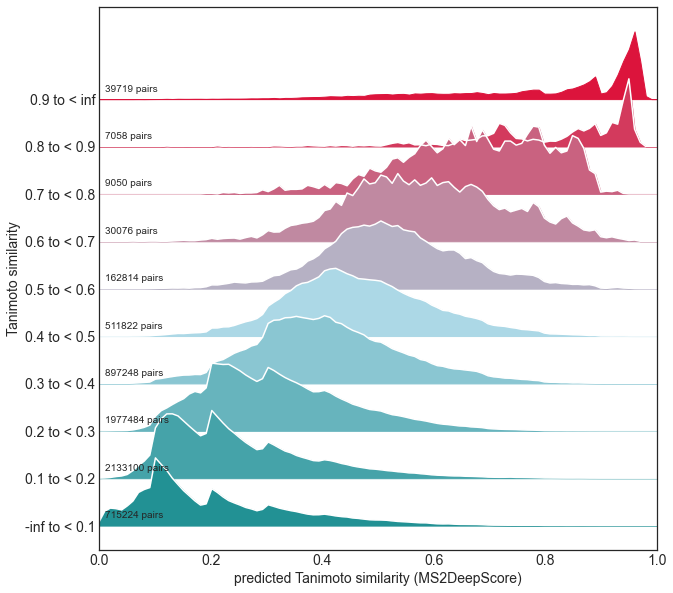

In [72]:
create_histograms_plot(scores_ref[idx_all], similarities_test_mc['score'][idx_all], n_bins=10, hist_resolution=100,
                       ref_score_name="Tanimoto similarity", compare_score_name="predicted Tanimoto similarity (MS2DeepScore)")

In [ ]:
# needs better interpolation etc.

In [81]:
from scipy.stats import pearsonr

top_percentage = 2

threshold = np.percentile(scores_ref.reshape(-1), (100-top_percentage)) # top 1% of scores
print(f"Pearsons correlation for top {top_percentage}% of scores (scores > {threshold:.4f})")
print(20 * "--")
idx = np.where(scores_ref.reshape(-1) >= threshold)

# calculate Pearson's correlation
corr, _ = pearsonr(scores_ref.reshape(-1)[idx], similarities_test_mc['score'].reshape(-1)[idx])
print(f"Pearsons correlation (Monte-Carlo median): {corr:.3f}")

idx = np.where(scores_ref[idx_all].reshape(-1) >= threshold)
corr, _ = pearsonr(scores_ref[idx_all].reshape(-1)[idx], similarities_test_mc['score'][idx_all].reshape(-1)[idx])
print(f"Pearsons correlation (Monte-Carlo median, selected): {corr:.3f}")

Pearsons correlation for top 2% of scores (scores > 0.5472)
----------------------------------------
Pearsons correlation (Monte-Carlo median): 0.518


<ipython-input-81-24808e58b2f0>:14: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  idx = np.where(scores_ref[idx_all].reshape(-1) >= threshold)
<ipython-input-81-24808e58b2f0>:15: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  corr, _ = pearsonr(scores_ref[idx_all].reshape(-1)[idx], similarities_test_mc['score'][idx_all].reshape(-1)[idx])


Pearsons correlation (Monte-Carlo median, selected): 0.589
